<a href="https://colab.research.google.com/github/adityarrestu/jst-uas/blob/main/KlasifikasiJST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memanggil Dataset


In [1]:
import pandas as pd

dataset_url = 'https://raw.githubusercontent.com/adityarrestu/jst-uas/main/dataset_komentar_instagram_cyberbullying.csv'

df = pd.read_csv(dataset_url)
df.head()

,Id,Label,Comment
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


negative    200
positive    200
Name: Label, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


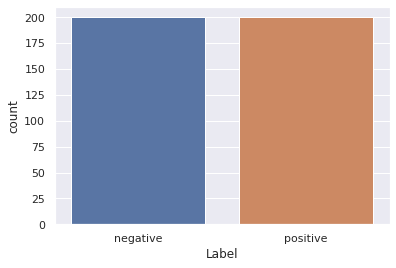

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

print(df['Label'].value_counts())
print('\n')
print(sns.countplot(df['Label']))

# Data Preprocessing

In [3]:
import re

def case_folding(data):
  temp_comment = []

  for comment in data:
    comment = re.sub(r"(?:\@|https?\://)\S+", "", comment)
    comment = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*,]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", comment)
    comment = re.sub(r"http\S+", "", comment)
    comment = re.sub('\n', '', comment)
    comment = re.sub('USERNAME', '', comment)
    comment = re.sub("[^a-zA-Z^']", " ", comment)
    comment = re.sub(" {2,}", " ", comment)
    comment = re.sub(r'\s+', ' ', comment)
    comment = comment.strip()
    comment = comment.lower();
    temp_comment.append(comment)
  return temp_comment

In [4]:
df['Comment']=case_folding(df['Comment'])
df.head()

,Id,Label,Comment
0,1,negative,tolol gak ada hubungan nya keguguran dgn pake ...
1,2,negative,geblek lo tata cowo bgt dibela in balikan hade...
2,3,negative,kmrn termewek skr lengket lg duhhh kok labil b...
3,4,negative,intinya kalau kesel dengan att nya gausah ke a...
4,5,negative,hadewwwww permpuan itu lg sakit jiwa knp harus...


In [5]:
print(df['Comment'][df.Label == 0])

Series([], Name: Comment, dtype: object)


In [6]:
import nltk
nltk.download('punkt')

def tokenized(data):
  return data.apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df['Comment']=tokenized(df['Comment'])
df.head()

,Id,Label,Comment
0,1,negative,"[tolol, gak, ada, hubungan, nya, keguguran, dg..."
1,2,negative,"[geblek, lo, tata, cowo, bgt, dibela, in, bali..."
2,3,negative,"[kmrn, termewek, skr, lengket, lg, duhhh, kok,..."
3,4,negative,"[intinya, kalau, kesel, dengan, att, nya, gaus..."
4,5,negative,"[hadewwwww, permpuan, itu, lg, sakit, jiwa, kn..."


In [8]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(data):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  return [stemmer.stem(comment) for comment in data]

In [ ]:
df['Comment'] = df['Comment'].apply(stemming)
df.head()

In [ ]:
import requests

slang_word = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt').text
dict_slang = eval(slang_word)
dict_slang.items()

In [ ]:
slang_df = pd.DataFrame(dict_slang.items(), columns=['Old', 'New'])
slang_df.head()

In [ ]:
slang_df['Old'] = slang_df['Old'].apply(lambda x: x.strip())
slang_df['New'] = slang_df['New'].apply(lambda x: x.strip())

In [ ]:
slang_dict = {}
for i, row in slang_df.iterrows():
  slang_dict.update({row['Old']: row['New']})

In [ ]:
def removeSlang(data):
  for i, word in enumerate(data):
    # check if data in slang dictionary or not
    try:
      data[i] = slang_dict[word]
    # if data is not slang then pass
    except KeyError:
      pass
  return data

In [ ]:
df['Comment'] = df['Comment'].apply(removeSlang)
df.head()

# Stop Words Removal

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def removeStopWords(data):
  stop_words = set(stopwords.words('indonesian'))
  return data.apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
df['Comment']=removeStopWords(df['Comment'])
df.head()

# Finalisasi


Ubah target (Label) value

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'negative' else 0)
df.head()

Kombinasi data menjadi satu string

In [ ]:
df['Comment'] = df['Comment'].apply(lambda x: ' '.join(x))
df.head()

# Word Cloud


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(df['Comment'][df.Label == 0])
text_neg = " ".join(df['Comment'][df.Label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Komentar Bukan Ujaran Kebencian')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Komentar Ujaran Kebencian')
plt.show()

# Text Vectorization (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['Comment']
label = df['Label']

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vector = tfidf_vectorizer.fit_transform(X)
tfidf_vector.shape

# Balanced Dataset

In [ ]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE()
tfidf_vector, label = sampler.fit_resample(tfidf_vector, label)
print(tfidf_vector.shape)
print(label.shape)

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_vector, label, test_size=0.2, shuffle=True, random_state=42)

# Hasil dari pembagian dataset
kalkulasi_train = y_train.value_counts()
kalkulasi_test = y_test.value_counts()
print("Total data latih : \n", kalkulasi_train)
print("Total data tes : \n", kalkulasi_test)

# Membuat Model Backpropagation Neural Network

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train).toarray()
X_test = sc.fit_transform(X_test).toarray()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

# Add model for Neural Network
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
          
model.summary()

In [ ]:
# run model
history = model.fit(X_train, y_train, epochs=10, verbose=True, validation_data=(X_test, y_test), batch_size=10)

In [ ]:
# Check the Accuracy
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Plot accuracy
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

In [ ]:
def prediksi(comment):
  vectorized_comment = tfidf_vectorizer.transform(comment).toarray()
  input_prediction = model.predict(vectorized_comment)

  print('text :', comment[0])
  if input_prediction[0][0]>=0.54:
    print("\nPrediksi : \nkomentar ujaran kebencian!!!")
  else:
    print("\nPrediksi : \nbukan komentar ujaran kebencian")

In [ ]:
prediksi(["Alhamdulilah persib menang hari ini"])

In [ ]:
prediksi(["Messi kafir anjing"])